Do this BEFORE running bash run_xray

In [1]:
import scipy.io as scio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = './data/XrayBaggage20/'
#data_A = scipy.io.loadmat(data_dir+'XrayDataset-'+domainSet[sourceDomainIndex]+'-resnet101-noft.mat')
#data_A = scipy.io.loadmat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/CRISPR.mat')
        
data1=scio.loadmat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/XrayDataset-regu-resnet101-noft.mat')
data2=scio.loadmat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/XrayDataset-xray-resnet101-noft.mat')
        
# This is the collection of CRISPR and Compound, however, they are 300 dimensional, we want to convert it back to original 900 dimensional
# Thus, we introduce the xyz file which is the collection of all data with 900 dimensional feature, but we need to filer the desired samples out
df1 = pd.read_csv('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/total_CRISPR.csv')
df2 = pd.read_csv('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/total_compound.csv')
df1=df1.iloc[:,1:]
df2=df2.iloc[:,1:]
df3=pd.concat([df1,df2])
df3=df3.reset_index()
Gene_list=df3['Metadata_gene'].tolist()       

In [5]:
# df3: combination of all CRISPR and COMPOUND 
# Convert the shape and contents of df3
dvv=df3['Metadata_gene'].reset_index()
labels, unique_labels = pd.factorize(df3['Metadata_gene'])
label_list=labels.tolist()
dvv['intlab']=labels
dvv=dvv.iloc[:,1:]
mapping_dict = dict(zip(unique_labels, labels))
df3['Metadata_gene']=pd.factorize(df3['Metadata_gene'])[0]
        
### Source: Pure CRISPR
df3=df3.reset_index()
# because CRISPR and Compund are stacked in order, we need to locate the position of the last CRISPR
df11=df3.iloc[:len(df3[df3['Metadata_experiment_type']=='CRISPR']),1:] 
df11=df11.reset_index()
df11=df11.iloc[:,1:]
## Target: Pure Compound
df22=df3.iloc[len(df3[df3['Metadata_experiment_type']=='CRISPR']):,1:]
df22=df22.reset_index()
df22=df22.iloc[:,1:]
        
        
        
#Convert and save source in .mat
df11['Metadata_gene']=df11['Metadata_gene'].astype('int64')
dfx=df11.iloc[:,16:]
dfx=np.array(dfx)
dfy=df11['Metadata_gene']
dfy=np.array(dfy)
dfy=dfy.reshape(1,-1)
data1['labels']=dfy
data1['resnet101_features']=dfx
        
#Convert and save target in .mat
df22['Metadata_gene']=df22['Metadata_gene'].astype('int64')
dfx=df22.iloc[:,16:]
dfx=np.array(dfx)
dfy=df22['Metadata_gene']
dfy=np.array(dfy)
dfy=dfy.reshape(1,-1)
data2['labels']=dfy
data2['resnet101_features']=dfx
# Source 
data_A=data1
# Target
data_B=data2
# Source Domain
scio.savemat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/data_A.mat',data_A)
# Target Domain
scio.savemat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/data_B.mat',data_B)

In [6]:
# This is a list includes Original Genes and its Numerical representation applied in CCVAE
# Just for convenient 
# Use it when we want to transform Numerical labels back to original str labels
Gene_tonum=pd.DataFrame({'Gene': Gene_list,'To_Num': label_list})
Gene_tonum=Gene_tonum.drop_duplicates()

In [23]:
# Seen with transformed data
dfte1a=pd.read_csv('/data/datacenter/H3C_GPU/projects/yuchen/MLP_seen_ccvae.csv') #seen
dfte1a=dfte1a.iloc[:,2:-1]
dfte1a=dfte1a[dfte1a['Metadata_gene']!='empty']
dfte1a=dfte1a[dfte1a['Metadata_control_type']!='negcon']
dfte1a=dfte1a[dfte1a['Metadata_experiment_type']=='Compound']
dfte1a['unseen'] = 0
# uneen with transformed data
dfte2a=pd.read_csv('/data/datacenter/H3C_GPU/projects/yuchen/MLP_unseen_ccvae.csv') #unseen
dfte2a=dfte2a.iloc[:,2:-1]
dfte2a=dfte2a[dfte2a['Metadata_gene']!='empty']
dfte2a=dfte2a[dfte2a['Metadata_control_type']!='negcon']
dfte2a=dfte2a[dfte2a['Metadata_experiment_type']=='Compound']
dfte2a=dfte2a.reset_index()
dfte2a=dfte2a.iloc[:,1:]
dfte2a['unseen']= 1
# Filter out the compound perturbation from the Total_dataframe
df = df3[df3['Metadata_experiment_type']=='Compound']
# Construct two columns which let us know the split: train/test and know if it is unseen (0: seen, 1:unseen)
df['split']=np.nan
df['unseen']=np.nan
df=df.iloc[:,3:]
df=df.reset_index()
# Here is to match the split strategy and if_seen
for i in range(len(dfte1a)):
    pla=dfte1a['Metadata_Plate'][i]
    wel=dfte1a['Metadata_Well'][i]
    for j in range(len(df)):
        pla0=df['Metadata_Plate'][j]
        wel0=df['Metadata_Well'][j]
        if pla0==pla and wel0==wel:
            #print('yes!!')
            df['split'][j]=2
            df['unseen'][j]=0
for i in range(len(dfte2a)):
    pla=dfte2a['Metadata_Plate'][i]
    wel=dfte2a['Metadata_Well'][i]
    for j in range(len(df)):
        pla0=df['Metadata_Plate'][j]
        wel0=df['Metadata_Well'][j]
        if pla0==pla and wel0==wel:
            #print('yes!!')
            df['split'][j]=2
            df['unseen'][j]=1
# Data Convert
df['split']=df['split'].fillna(1)
df['split']=df['split'].astype(int)
df['unseen']=df['unseen'].fillna(0)
df['unseen']=df['unseen'].astype(int)
# This is to store the split strategy in array so that we can merge it in .mat format
dfk=df['split']
dfk=np.array(dfk)

# This is to store the If_seen definition in array and convert it into .mat via array
df_gene_ifseen = pd.DataFrame({'Gene':df['Metadata_gene'].tolist(),'If_Seen': df['unseen'].tolist()})
df_gene_ifseen=df_gene_ifseen.drop_duplicates()
df_gene_ifseen=df_gene_ifseen.sort_values(by='Gene')
#Ifseen = np.array(df_gene_ifseen['If_Seen'])
Ifseen_lst= np.zeros(130,dtype=np.int64).tolist()
for index, row in df_gene_ifseen.iterrows():
    Ifseen_lst[row['Gene']] = row['If_Seen']
Ifseen_lst=np.array(Ifseen_lst)
# This is to fill the two arrays into .mat file
dataSplit=scio.loadmat(data_dir+'instanceSplit_xrayDataset_unseen10.mat')
for i in range(0,5):
    for j in range(0,2):
        dataSplit['targetDomain_splitFlag'][0][i][0][j]=dfk
        dataSplit['targetDomain_unseenClass'][0][i][0][j]= Ifseen_lst
scio.savemat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/dataSplit1.mat',dataSplit)


/tmp/ipykernel_252483/1573348686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split']=np.nan
/tmp/ipykernel_252483/1573348686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unseen']=np.nan
/tmp/ipykernel_252483/1573348686.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'][j]=2
/tmp/ipyker

In [ ]:
#data_A['resnet101_features'].shape

In [ ]:
#data_B['resnet101_features'].shape

In [ ]:
#len(dataSplit['targetDomain_unseenClass'][0][0][0][0])

Do this AFTER running bash run_xray

In [39]:
lab=unique_labels.tolist()
dww=dvv.drop_duplicates()
spp=scio.loadmat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/dataSplit1.mat')
spp1=spp['targetDomain_unseenClass'][0][0][0][0][0]
ccc=scio.loadmat('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/results/xray10-regu-xray-trial0-vaeEpochs-50-latSize-64lr0.001.mat')
n=10
top_indices = np.argpartition(-ccc['acc_per_class'][49], n)[:n][~np.isnan(ccc['acc_per_class'][49][np.argpartition(-ccc['acc_per_class'][49], n)[:n]])]
lst1=[]
lst2=[]
for i in top_indices:
    lst1.append(dvv[dvv['intlab']==i].iloc[0,:]['Metadata_gene'])
    lst2.append(ccc['acc_per_class'][49][i])
#pd.DataFrame({'label': lst1, 'Accuracy': lst2}).sort_values(by='Accuracy',ascending=False)

In [40]:
print('CCVAE_SEEN_AVG_ACC',ccc['acc_seen'][0][-1])
print('CCVAE_UNSEEN_AVG_ACC',ccc['acc_unseen'][0][-1])
print('CCVAE_TOTAL_AVG_ACC',ccc['acc'][0][-1])

CCVAE_SEEN_AVG_ACC 0.2910384525479196
CCVAE_UNSEEN_AVG_ACC 0.1698588709677419
CCVAE_TOTAL_AVG_ACC 0.2795884133434934


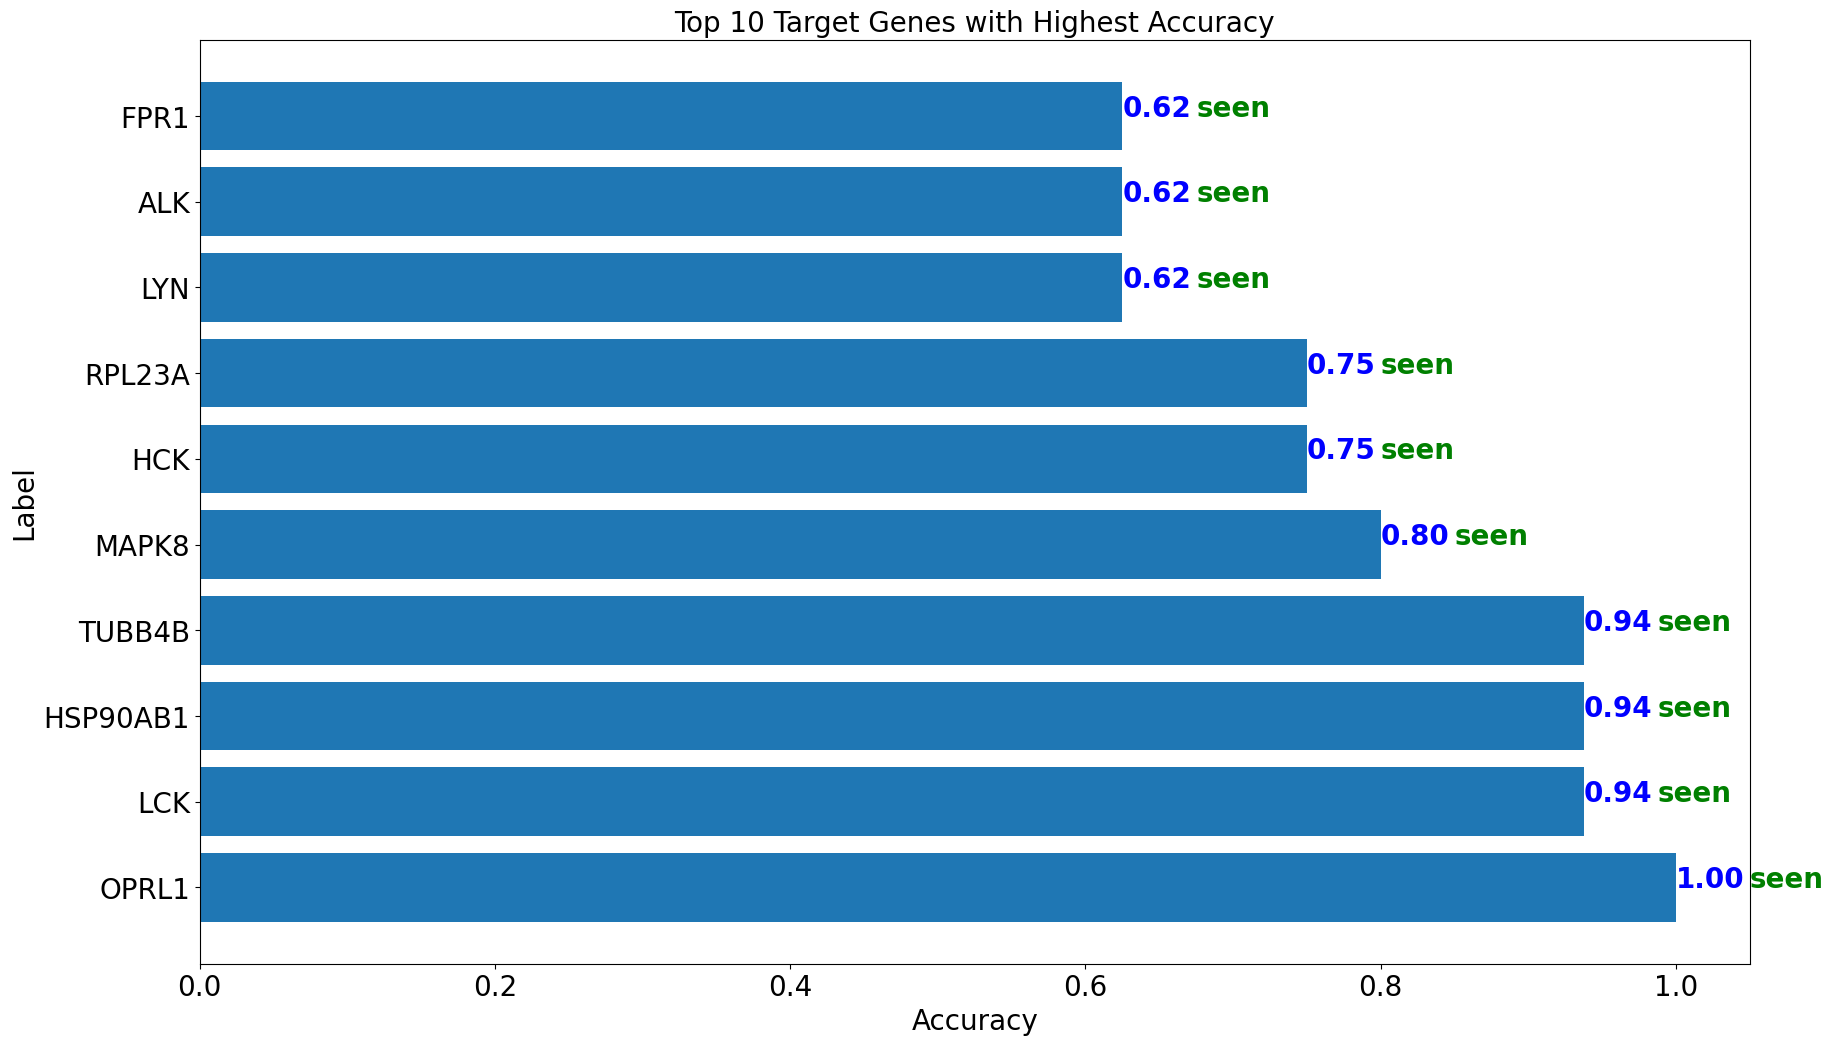

In [41]:
dr=pd.DataFrame({'Label': lab, 'Accuracy': ccc['acc_per_class'][49], 'If_seen': spp1})
dr['If_seen'] = dr['If_seen'].replace({0:'seen', 1:'unseen'})
dr=dr.dropna()
dr=dr.sort_values(by='Accuracy', ascending = False)
dr=dr.iloc[:10,:]
plt.figure(figsize=(20,12))
plt.barh(dr['Label'],dr['Accuracy'])
plt.xlabel('Accuracy',fontsize=20)
plt.ylabel('Label',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 10 Target Genes with Highest Accuracy',fontsize=20)
for i,(v,s) in enumerate(zip(dr['Accuracy'],dr['If_seen'])):
    plt.text(v,i,f'{v:.2f}', color = 'blue', fontweight = 'bold',fontsize=20)
    plt.text(v+0.05, i, s, color = 'green', fontweight = 'bold',fontsize=20)
plt.show()

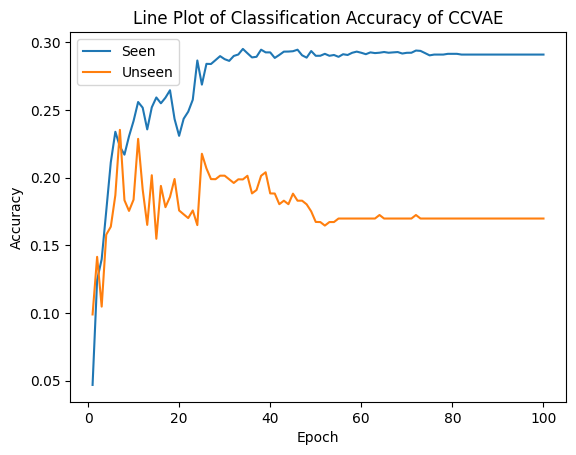

In [42]:
epochs = np.arange(1,101)
data1 = ccc['acc_seen'][0]
data2 = ccc['acc_unseen'][0]
plt.plot(epochs, data1, label='Seen')
plt.plot(epochs, data2, label='Unseen')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Line Plot of Classification Accuracy of CCVAE')
plt.legend()